In [83]:
import pandas as pd

# I skip 53-58 rows because that is where the metadata is so it is not helpful to read those lines 
# it actively messes up the data actually. I originally tried to do it iteratively but then thought
# it would just be easier to do in place

# I also opted to use the flask data since a lot of the observatories did not have in-situ readings.
# This way we would have a bit more standard/controlled readings.
df_ALT = pd.read_csv('data/monthly_flask_co2_alt.csv', skiprows=53)
df_CHR = pd.read_csv('data/monthly_flask_co2_chr.csv', skiprows=56)
df_KER = pd.read_csv('data/monthly_flask_co2_ker.csv', skiprows=56)
df_KUM = pd.read_csv('data/monthly_flask_co2_kum.csv', skiprows=56)
df_NZD = pd.read_csv('data/monthly_flask_co2_nzd.csv', skiprows=56)
df_SAM = pd.read_csv('data/monthly_flask_co2_sam.csv', skiprows=56)
df_MLO = pd.read_csv('data/monthly_flask_co2_mlo.csv', skiprows=56)
df_LJO = pd.read_csv('data/monthly_merge_co2_ljo.csv', skiprows=58)
df_PTB = pd.read_csv('data/monthly_merge_co2_ptb.csv', skiprows=58)
df_SPO = pd.read_csv('data/monthly_merge_co2_spo.csv', skiprows=58)


all_dataframes = [df_ALT, df_CHR, df_KER, df_KUM, df_NZD, df_SAM, df_MLO, df_LJO, df_PTB, df_SPO]
dataframe_names = ['ALT', 'CHR', 'KER', 'KUM', 'NZD', 'SAM', 'MLO', 'LJO', 'PTB', 'SPO']

column_names = ["Year", "Month", "Date1", "Date2", "CO2", "Szn_Adj", "Fit", "Szn_Fit", "CO2_Filled", "Szn_Fill"]

for i, df in enumerate(all_dataframes):
    df.columns = column_names
    df['Station'] = dataframe_names[i]
    
df_LJO.head()

Year  Month  Date1      Date2        CO2    Szn_Adj     Fit  Szn_Fit  \
0  1957      1  20835  1957.0411        NaN        NaN  314.48   313.02   
1  1957      2  20866  1957.1260        NaN        NaN  314.97   313.14   
2  1957      3  20894  1957.2027     315.45     313.32  315.39   313.25   
3  1957      4  20925  1957.2877     315.74     313.03  316.09   313.38   
4  1957      5  20955  1957.3699     315.84     313.03  316.30   313.50   

   CO2_Filled  Szn_Fill Station  
0      314.48    313.02     LJO  
1      314.97    313.14     LJO  
2      315.45    313.32     LJO  
3      315.74    313.03     LJO  
4      315.84    313.03     LJO

/Users/raphaelsorensen/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/raphaelsorensen/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


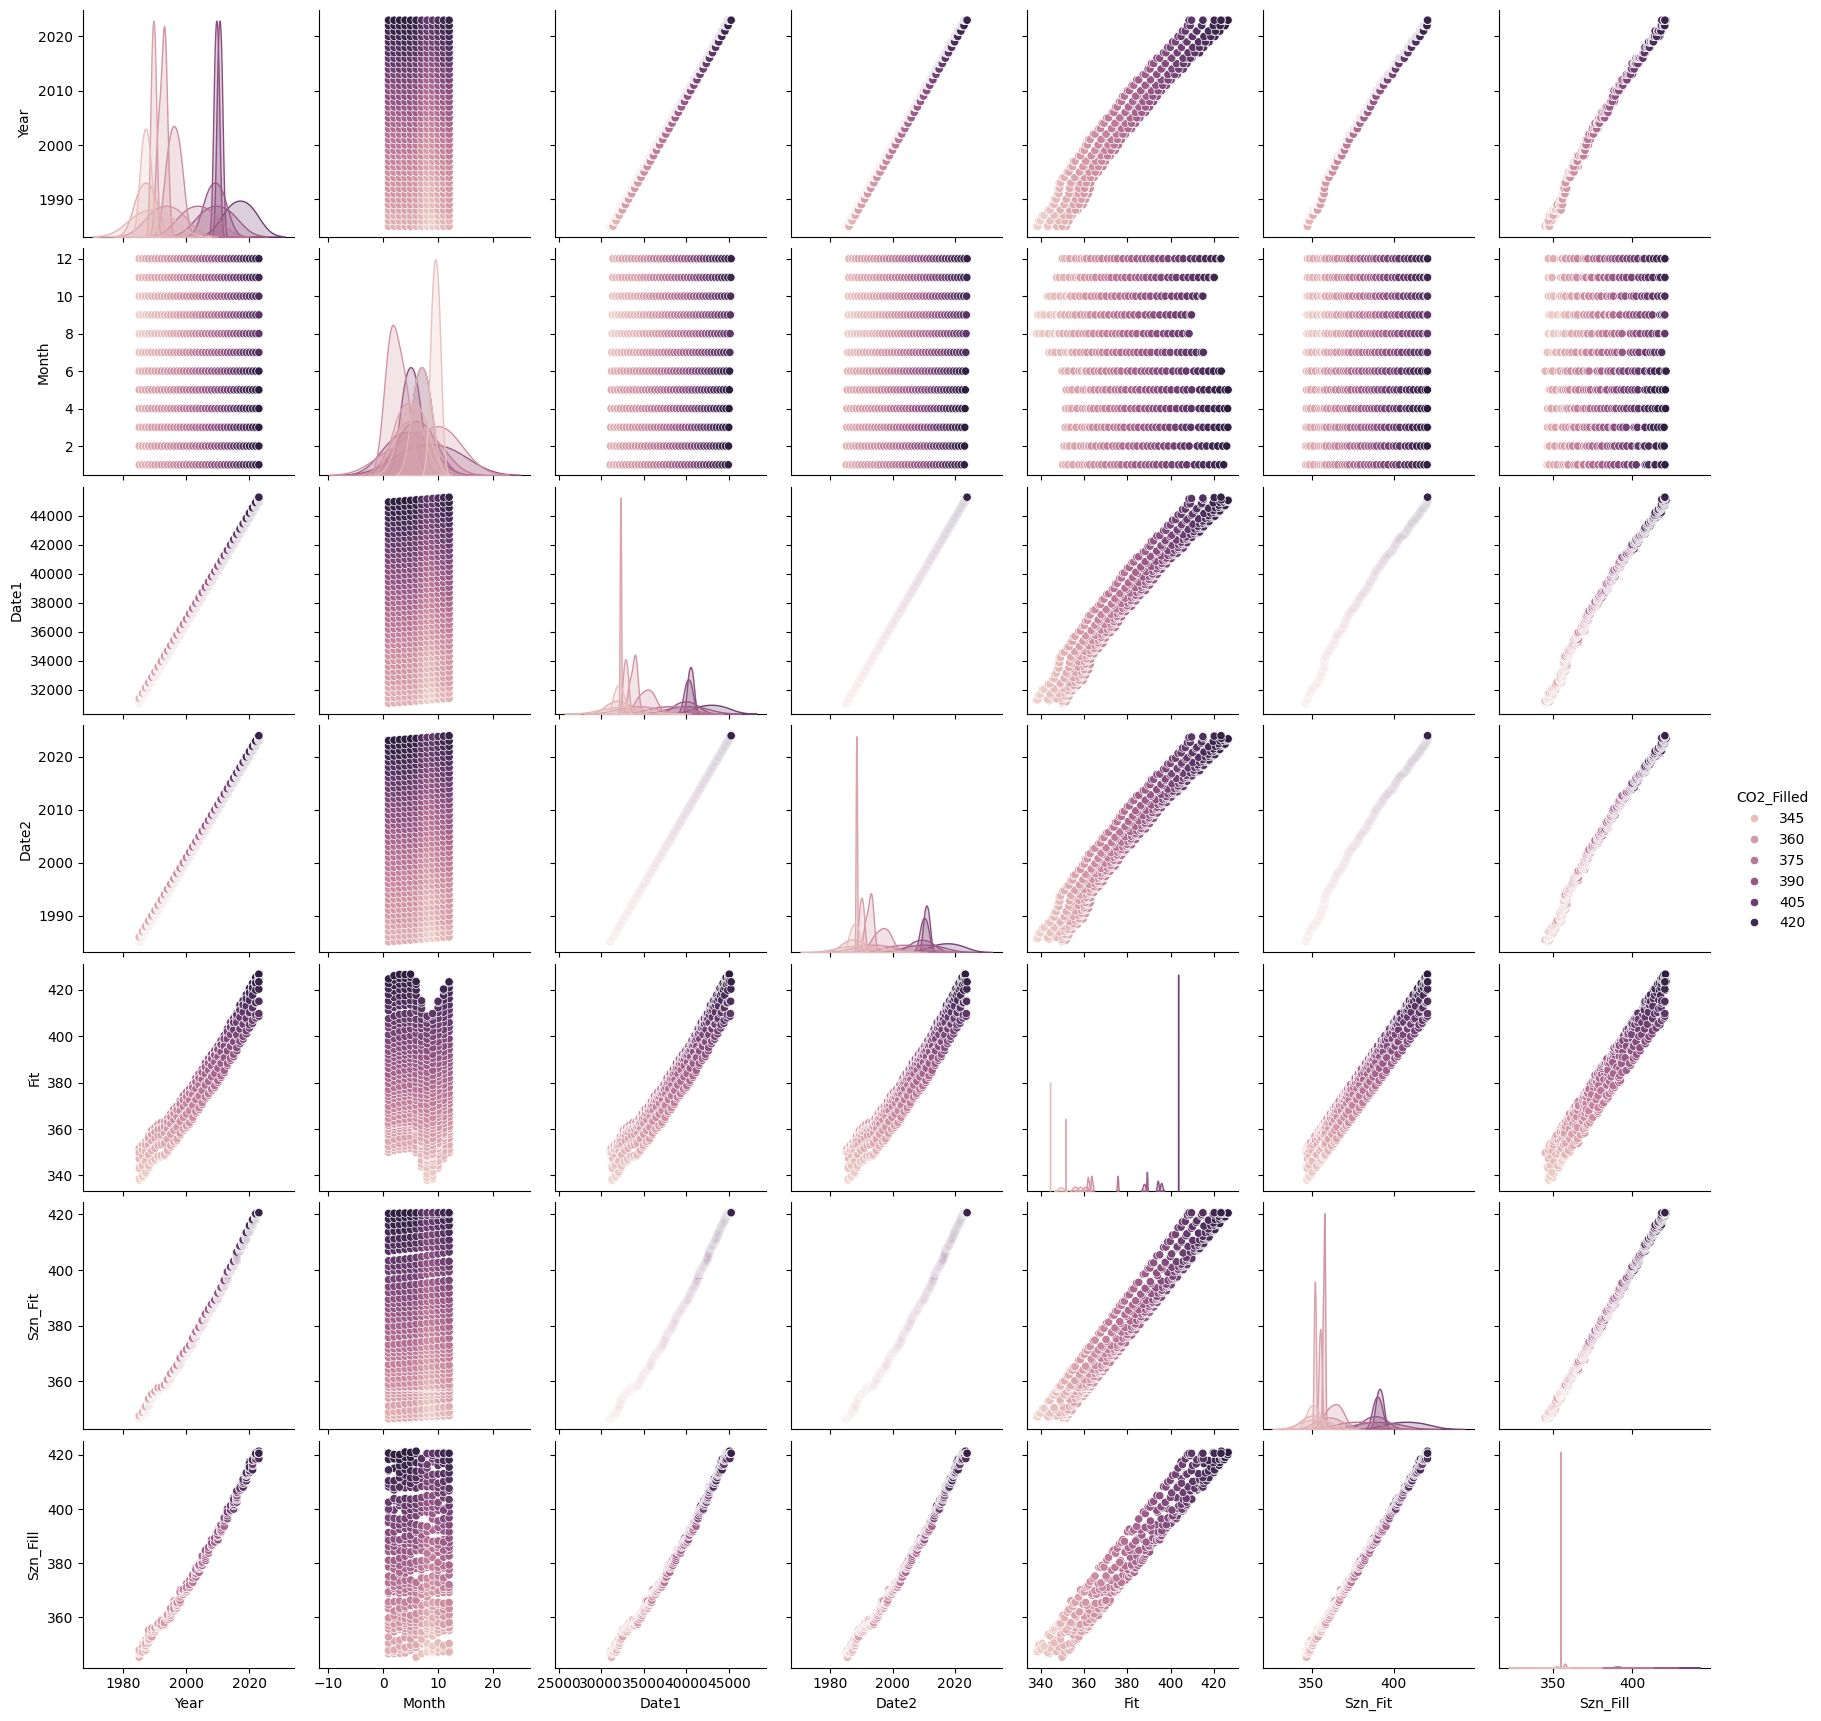

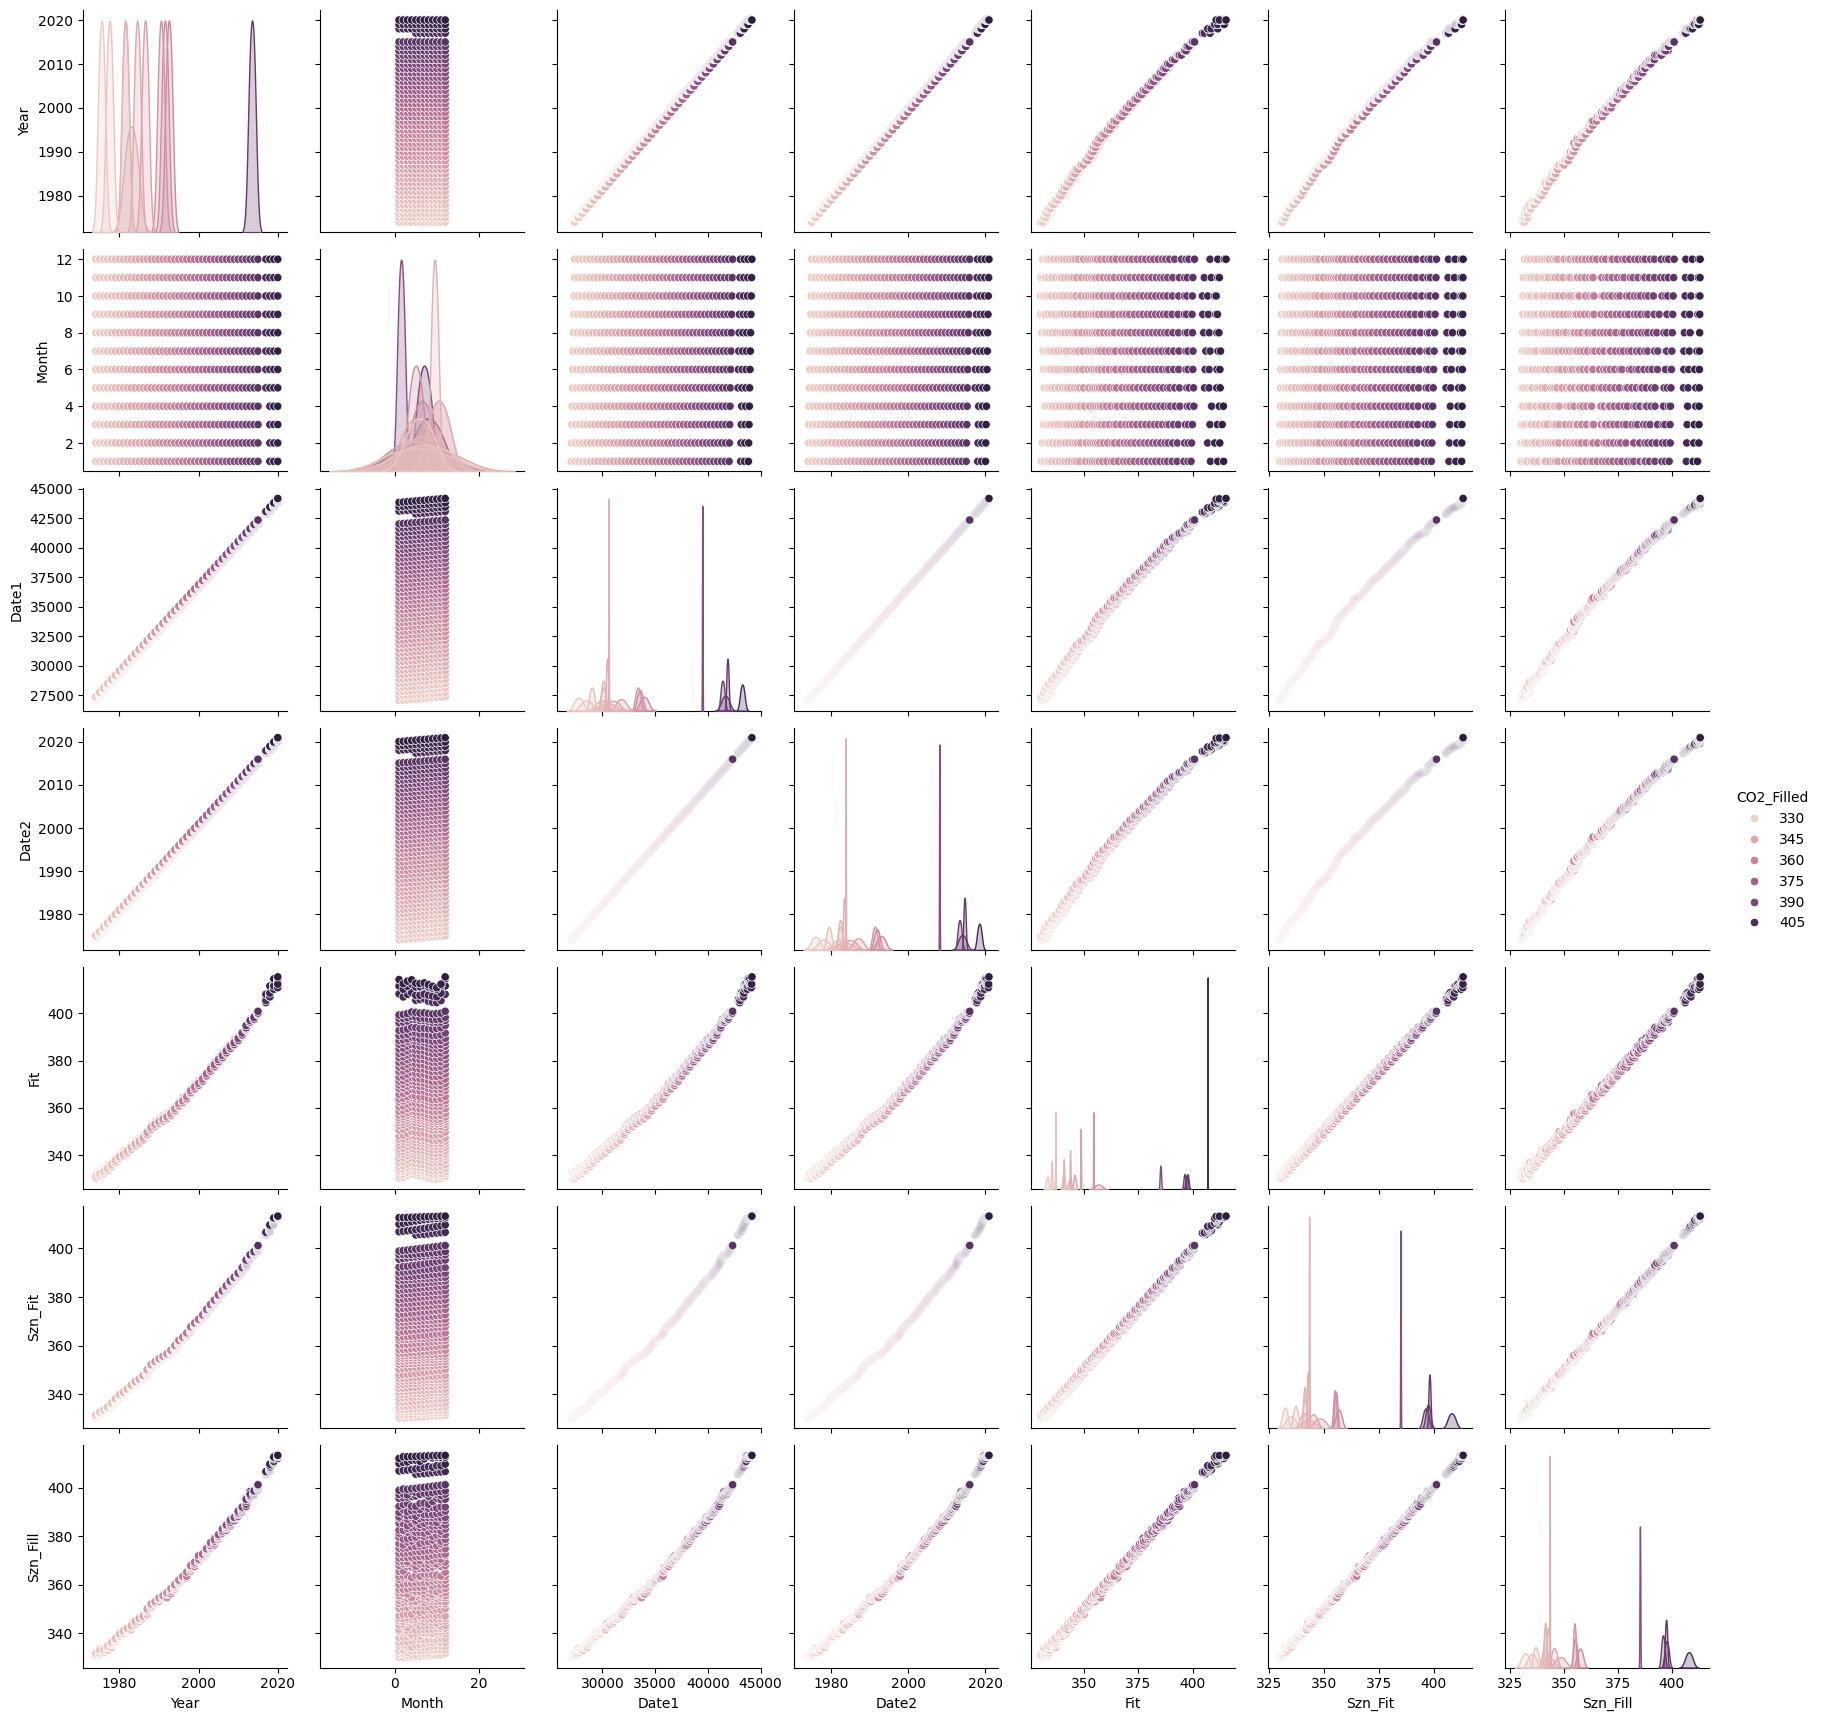

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_ALT, hue="CO2_Filled")
sns.pairplot(df_CHR, hue="CO2_Filled")
plt.show()

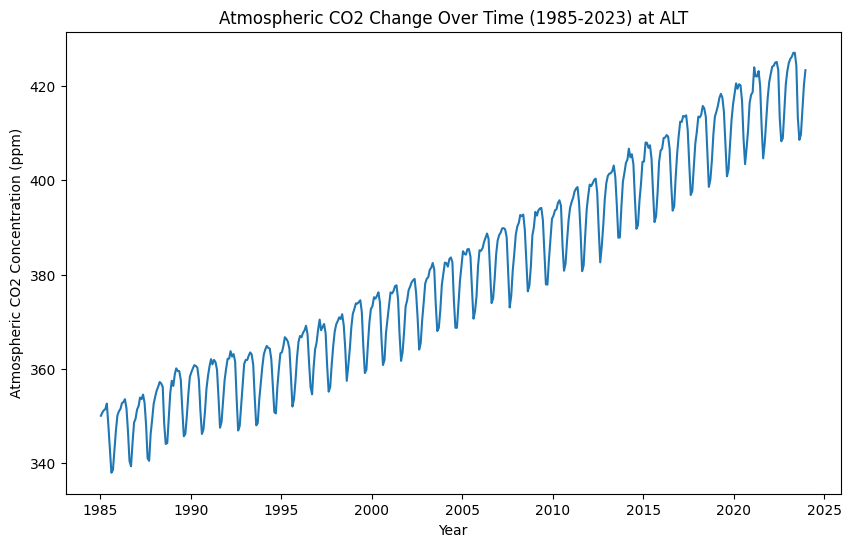

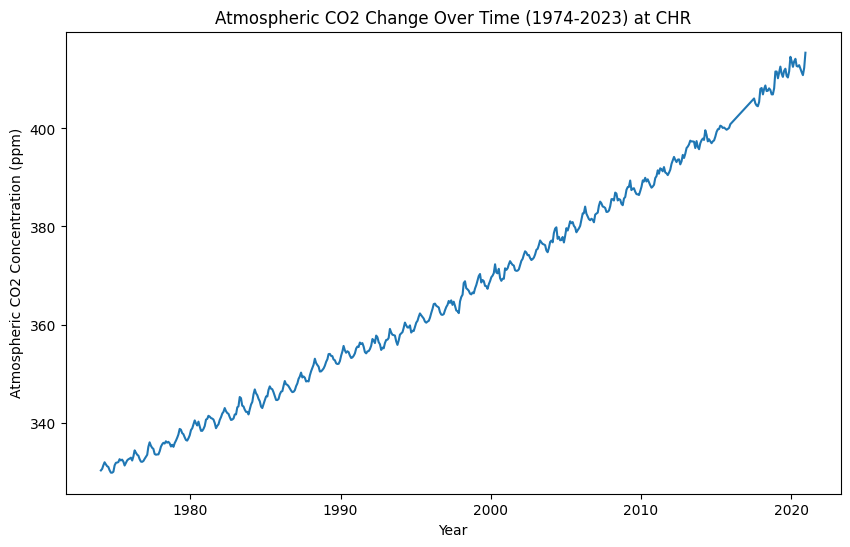

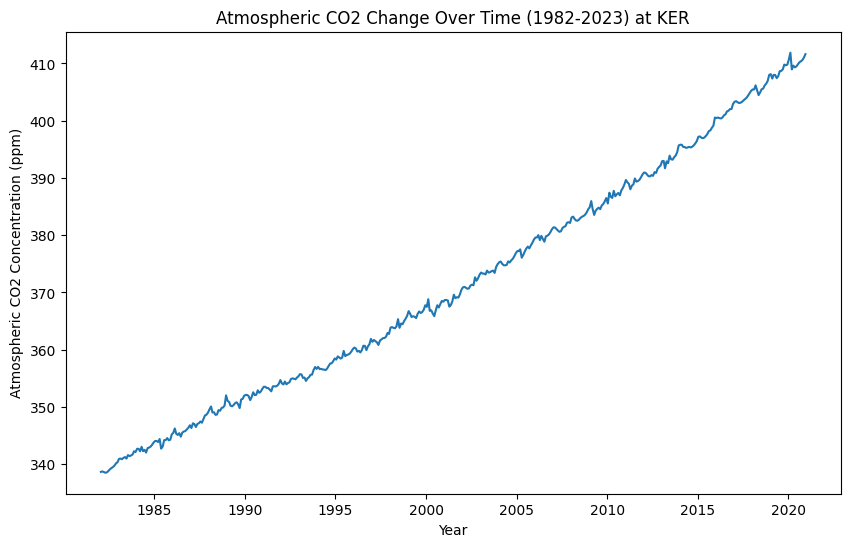

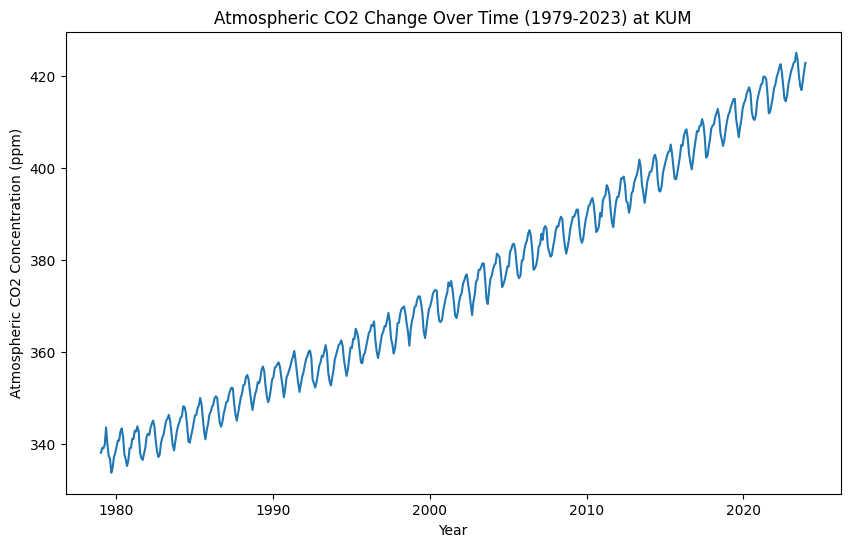

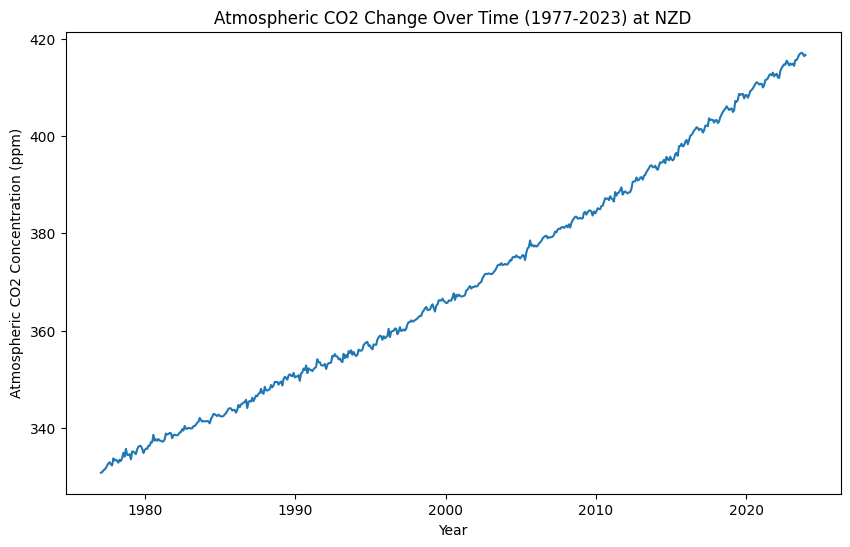

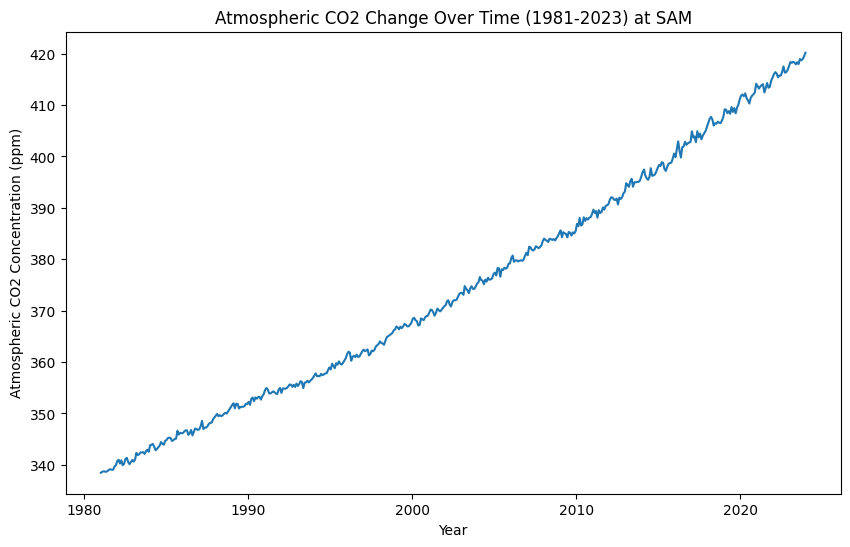

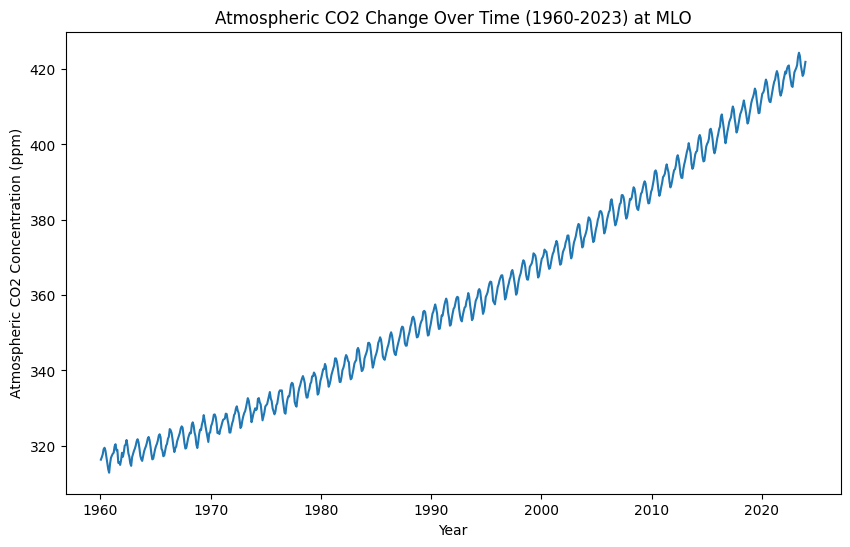

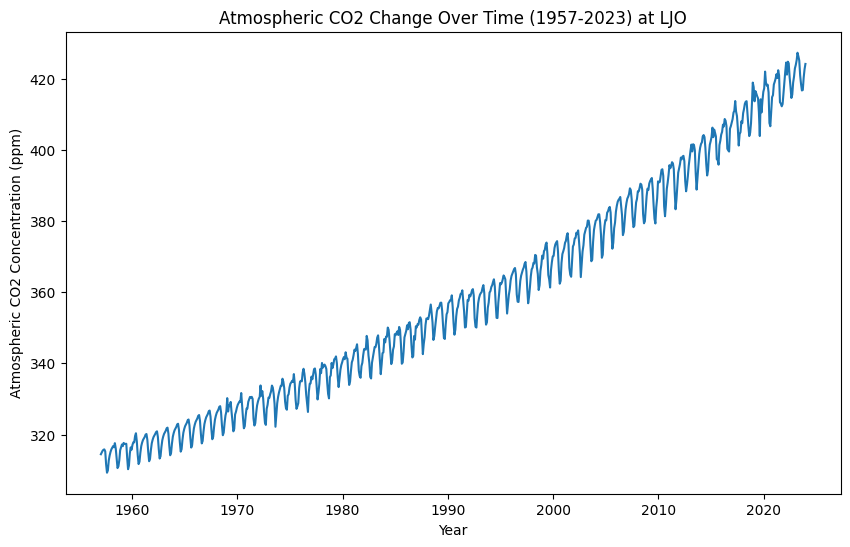

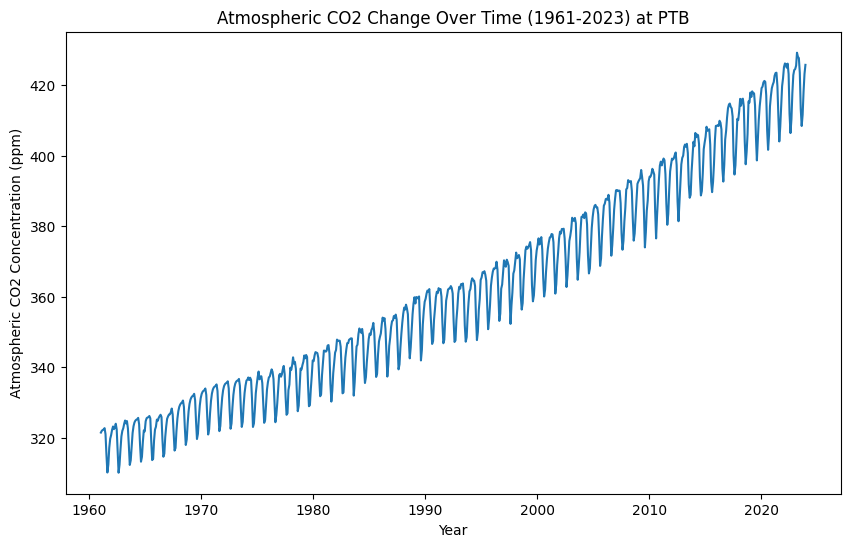

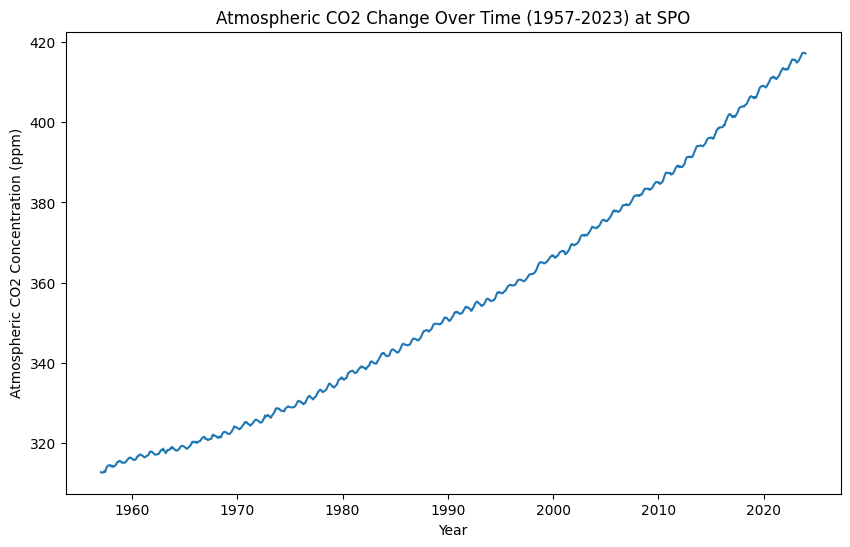

In [52]:
# from matplotlib.ticker import MultipleLocator

# initial settings for the plots

for df in all_dataframes:
    plt.figure(figsize = (10,6))
    plt.plot(df['Date2'], df['CO2_Filled'])
    
    plt.xlabel('Year')
    plt.ylabel('Atmospheric CO2 Concentration (ppm)')
    plt.title(f'Atmospheric CO2 Change Over Time ({df["Year"].iloc[0]}-2023) at {df["Station"].iloc[0]}')
    
    plt.show()


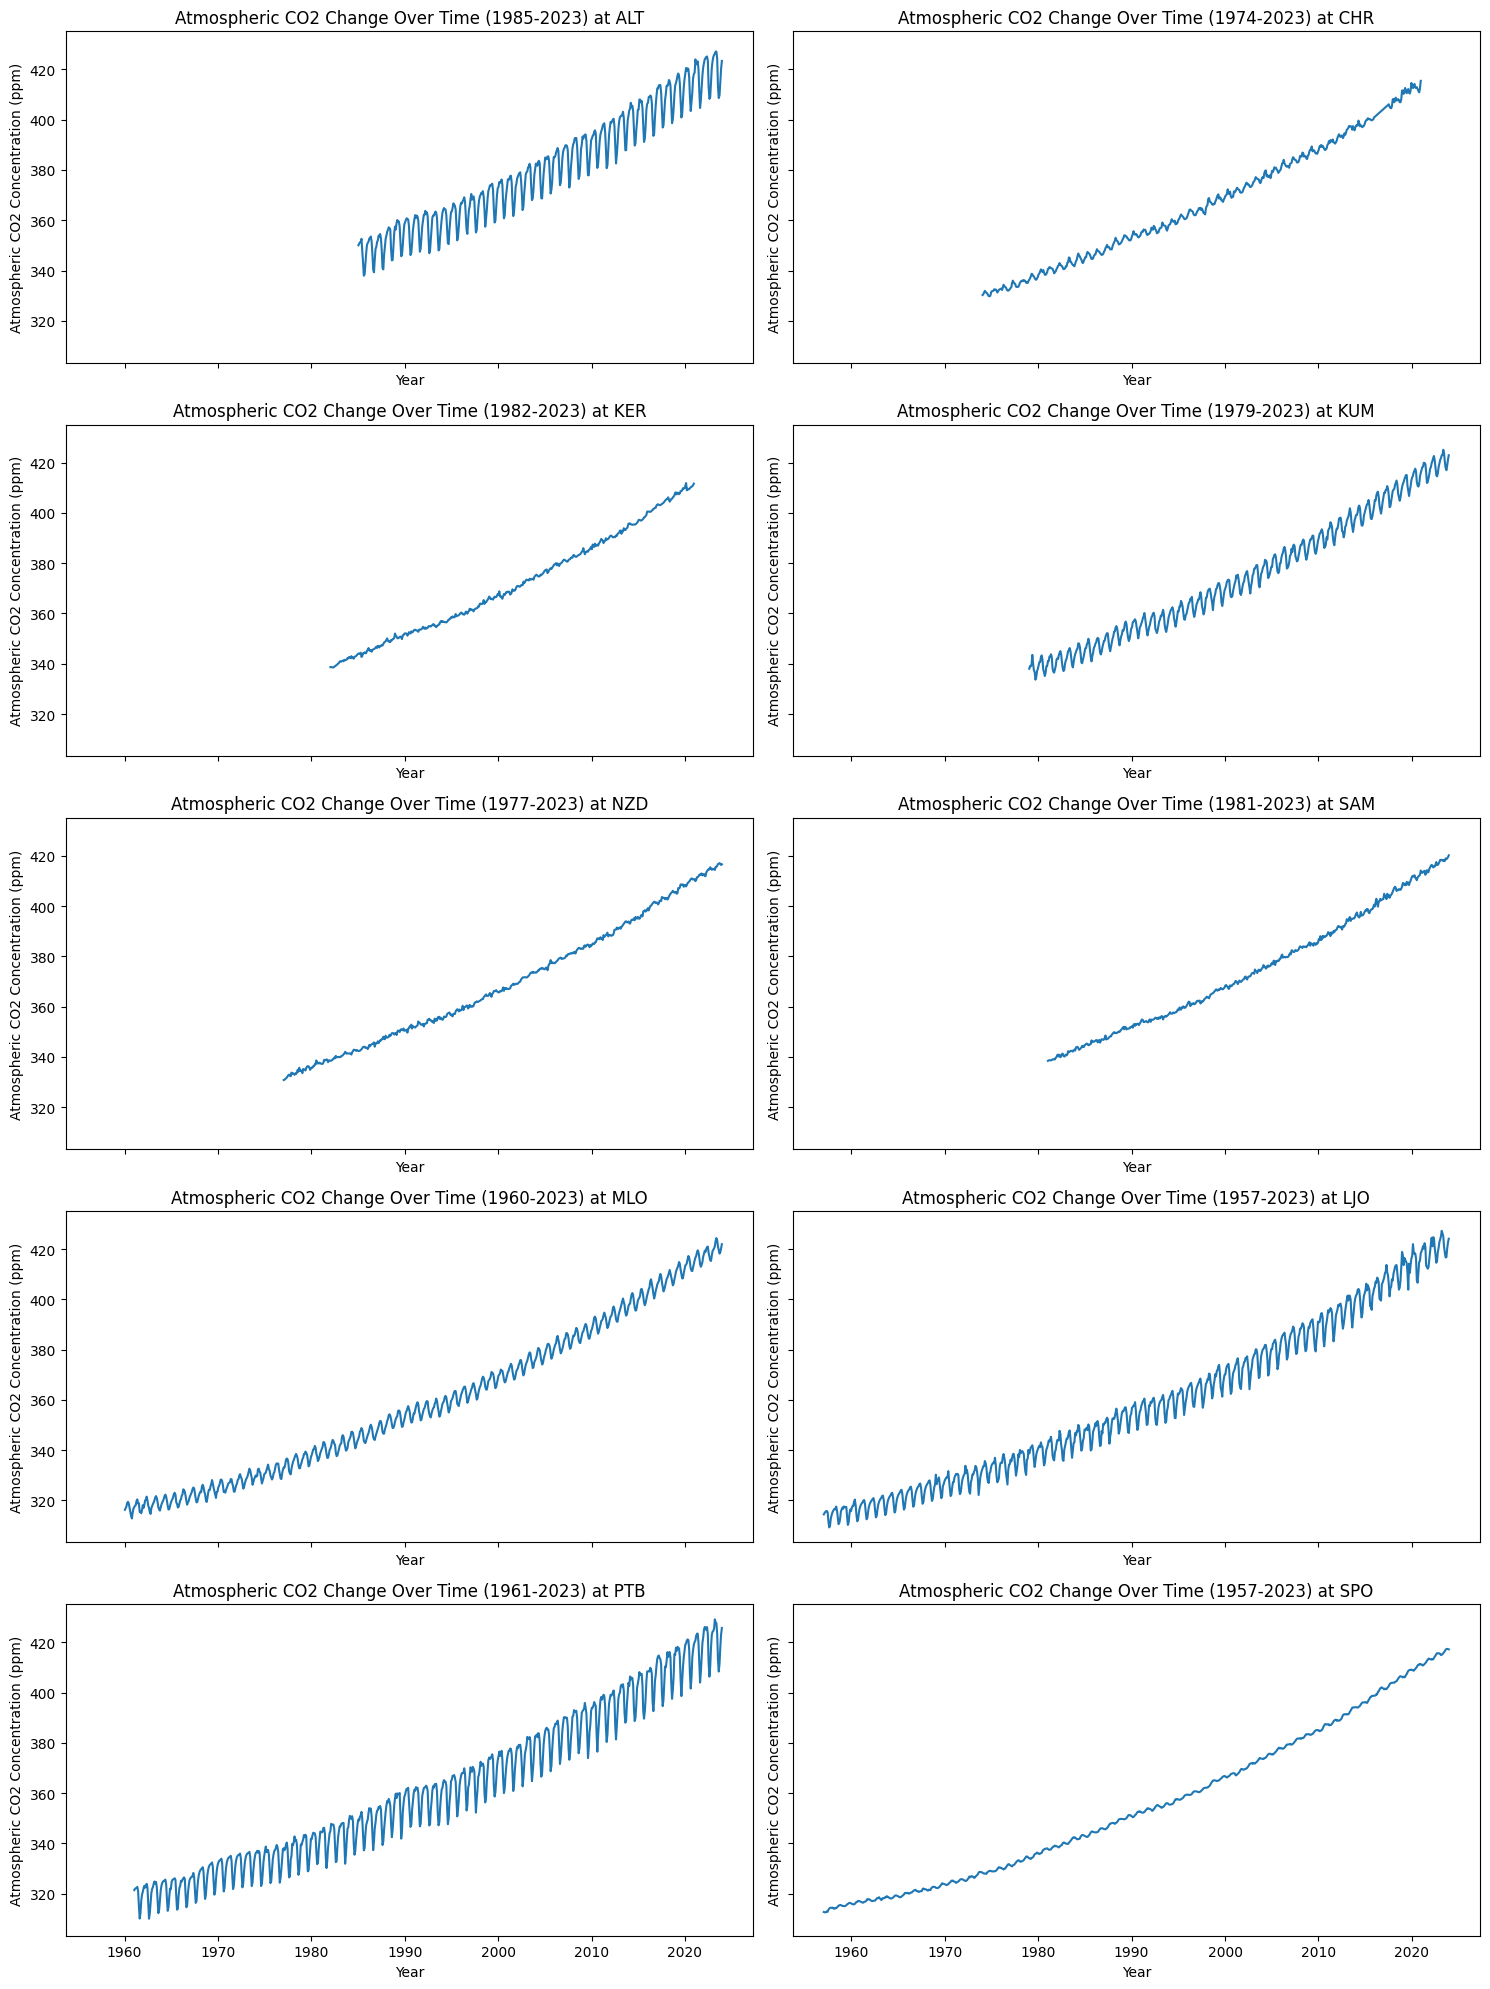

In [64]:
num_rows = 5
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20), sharex=True, sharey=True)

# Flatten the 2D array of subplots for easier iteration
axes = axes.flatten()

# Iterate over dataframes and create subplots
for i, (df, station_name) in enumerate(zip(all_dataframes, dataframe_names)):
    ax = axes[i]
    ax.plot(df['Date2'], df['CO2_Filled'])
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Atmospheric CO2 Concentration (ppm)')
    
    # Set the title based on the start year and station name of the current DataFrame
    ax.set_title(f'Atmospheric CO2 Change Over Time ({df["Year"].iloc[0]}-2023) at {station_name}')

# Adjust layout for better spacing
plt.tight_layout()

# Display the subplots
plt.show()

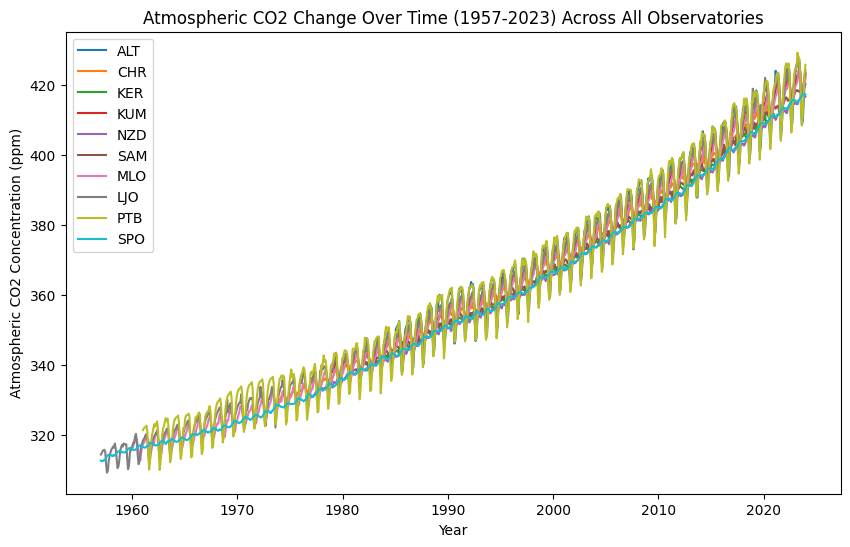

In [72]:
plt.figure(figsize = (10,6))

for df in all_dataframes:  
    plt.plot(df['Date2'], df['CO2_Filled'], label=df['Station'][0])
    
plt.xlabel('Year')
plt.ylabel('Atmospheric CO2 Concentration (ppm)')
plt.title('Atmospheric CO2 Change Over Time (1957-2023) Across All Observatories')
    
plt.legend(loc="upper left")
plt.show()

In [122]:
#['ALT', 'CHR', 'KER', 'KUM', 'NZD', 'SAM', 'MLO', 'LJO', 'PTB', 'SPO']
dataframe_latitude = [82.3, 2, -29.2, 19.5, -41.4, -14.2, 19.5, 32.9, 71.3, -90]

for i, df in enumerate(all_dataframes):
    df['Latitude'] = dataframe_latitude[i]


In [97]:
# Because they all start in january we can do a bit of cheating here and simply do a while loop and skip by 
# multiples of twelve

def CO2_spread_avg(dataset):
    spreads = dataset.groupby(dataset.index // 12)['CO2_Filled'].agg(lambda x: x.max() - x.min())
    '''
    Let's break this operation up into bits:
    
        (dataset.index // 12) is a floor division for every index in the dataset. So, from 0 - 11 because 
        all those numbers will result in a division less than 1 it will floor it to 0. Then for 12 - 23 it
        goes to 1 etc. This allows us to use the dataset.groupby method that takes groups within a pandas
        dataframe based on common traits. Since we have re-indexed all of our data into groups of 12 we can
        now take them as a whole!
        
        The agg function takes a function that will be performed along a column or axis. However, since we've
        just grouped the dataset we will be using agg to perform the function upon each of the groups. This
        function is the lambda function descibed below
        
        (lambda x: x.max() - x.min()) lambda functions are small anonymous functions (so if you really wanted
        you could just define a new function if that's easier for you) where in this case the 'x' is the 
        attribute that you are passing to the function, and is then getting operated on. So in this case the 
        'x' represents the grouped set of indices (months in this case) and we are finding the max value of 
        CO2 and subtracting from it the min CO2 value to get the spread.
    '''
    spreads = spreads.mean()
    
    return spreads
    

In [107]:

CO2_spreads = []
for station in all_dataframes:
    CO2_spreads.append(CO2_spread_avg(station))

sorted_indices = sorted(range(len(dataframe_latitude)), key=lambda k: dataframe_latitude[k])
''' 
First we get a generate a list of indices from 0 -> length of dataframe_latitude
Then we sort the list of indices based on what happens to the indices/values after they
are passed through the function 'lambda k: dataframe_latitude[k]'

So, we see [0] will be passed through the lambda function and it corresponds to the first value
in the dataframe_latitude df. Then it sorts the dataframe_latitude without actually sorting it
and just giving us the indices of where the sorted dataframe_latitude values should go. 
So if sorted indices gives us a list/df of [4, 2, 0, 1, 3] this would mean that in dataframe_latitude
the lowest value has index of 4, next lowest has index of 2 etc.
'''
lat_ordered = [dataframe_latitude[i] for i in sorted_indices]
CO2_ordered = [CO2_spreads[i] for i in sorted_indices]
all_df_ordered = [all_dataframes[i] for i in sorted_indices]

# Here we basically make new lists by iterating through the new sorted indices and pulling them out 
# from the dataframe_latitude list

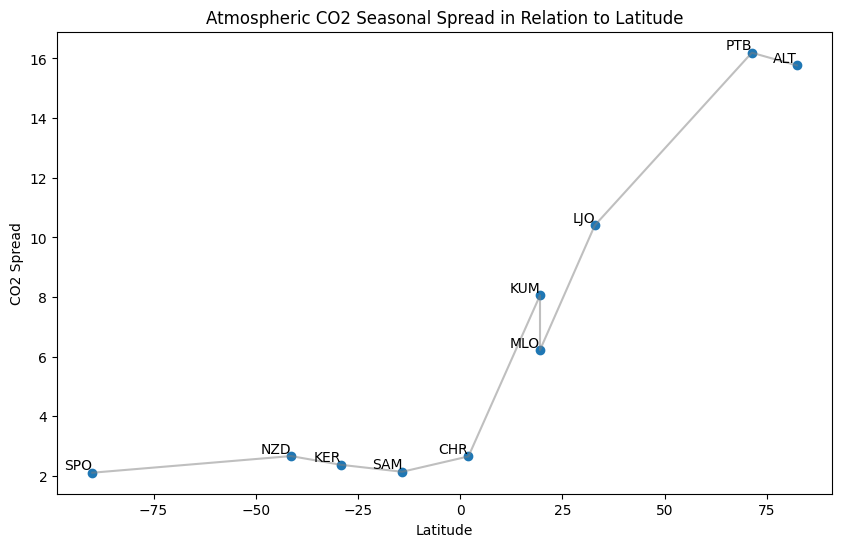

In [112]:
plt.figure(figsize = (10, 6))

plt.scatter(lat_ordered, CO2_ordered)
plt.plot(lat_ordered, CO2_ordered, linestyle = '-', color = 'gray', alpha = 0.5)

for i, (x_val, y_val) in enumerate(zip(lat_ordered, CO2_ordered)):
    plt.text(x_val, y_val, f"{all_df_ordered[i]['Station'].iloc[0]}", ha='right', va='bottom')
    
plt.xlabel('Latitude')
plt.ylabel('CO2 Spread')
plt.title('Atmospheric CO2 Seasonal Spread in Relation to Latitude')
    
plt.show()

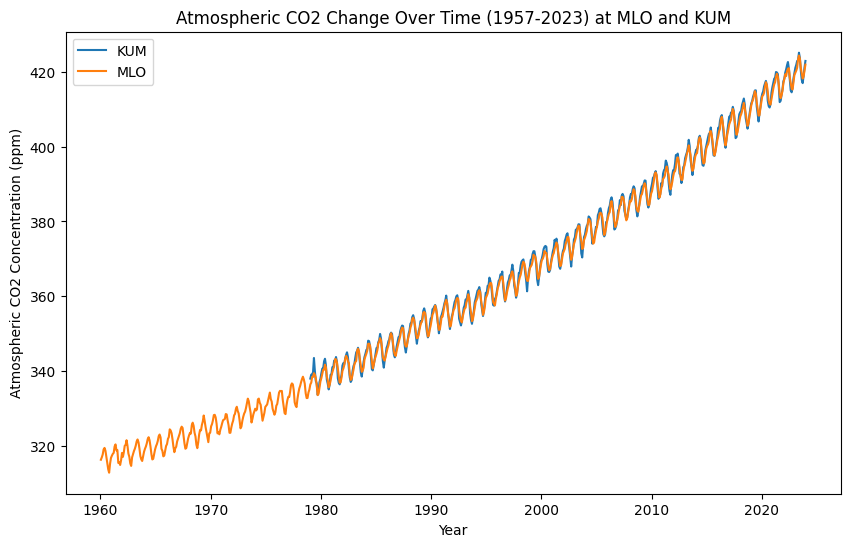

In [113]:
plt.figure(figsize = (10,6))


plt.plot(df_KUM['Date2'], df_KUM['CO2_Filled'], label=df_KUM['Station'].iloc[0])
plt.plot(df_MLO['Date2'], df_MLO['CO2_Filled'], label=df_MLO['Station'].iloc[0])

    
plt.xlabel('Year')
plt.ylabel('Atmospheric CO2 Concentration (ppm)')
plt.title('Atmospheric CO2 Change Over Time (1957-2023) at MLO and KUM')
    
plt.legend(loc="upper left")
plt.show()

Things to consider for the next part of the project. How does connection to larger land mass affect the seasonal variation. How does the latitude affect the spread? 
We can see that NZD is a much bigger island than: the Kermadec Islands, American Samoa, and "Christmas Island" which is really Kirubati, despite having a lower latitude it still experiences on average a larger seasonal spread marginal, but still there. I would like to look at why KUM and MLO have such varying consistencies in spread. Potentially has to do with the elevation, MLO is nearly 3.4 km above KUM

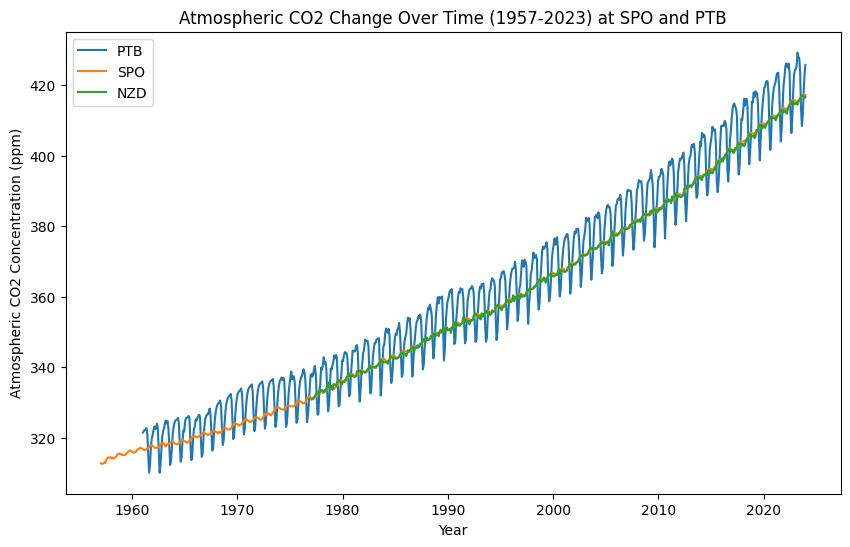

In [115]:
plt.figure(figsize = (10,6))


plt.plot(df_PTB['Date2'], df_PTB['CO2_Filled'], label=df_PTB['Station'].iloc[0])
plt.plot(df_SPO['Date2'], df_SPO['CO2_Filled'], label=df_SPO['Station'].iloc[0])


    
plt.xlabel('Year')
plt.ylabel('Atmospheric CO2 Concentration (ppm)')
plt.title('Atmospheric CO2 Change Over Time (1957-2023) at SPO and PTB')
    
plt.legend(loc="upper left")
plt.show()

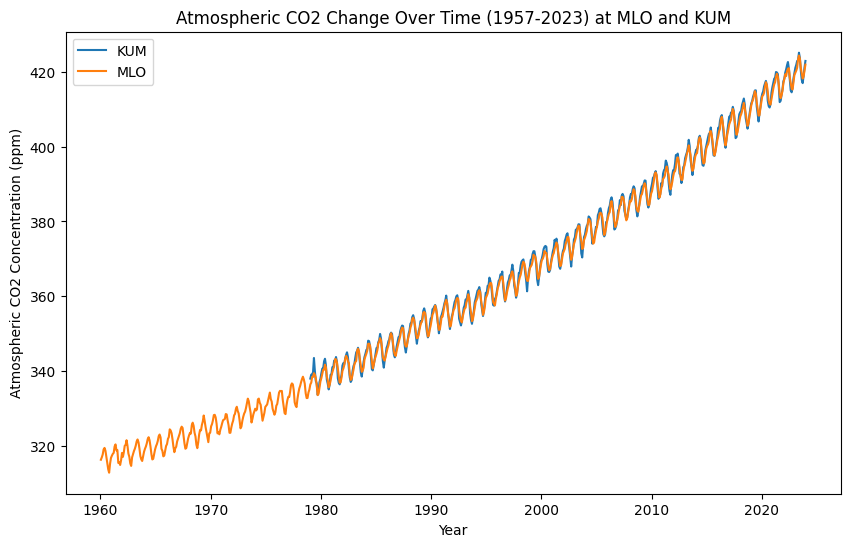

In [117]:
plt.figure(figsize = (10,6))


plt.plot(df_KUM['Date2'], df_KUM['CO2_Filled'], label=df_KUM['Station'].iloc[0])
plt.plot(df_MLO['Date2'], df_MLO['CO2_Filled'], label=df_MLO['Station'].iloc[0])


plt.xlabel('Year')
plt.ylabel('Atmospheric CO2 Concentration (ppm)')
plt.title('Atmospheric CO2 Change Over Time (1957-2023) at MLO and KUM')
    
plt.legend(loc="upper left")
plt.show()

In [187]:
# I'm going to look at the difference between the high points in the New Zealand readings vs.
# the PTB readings to get a sense of whether the human component pushes the Northern hemisphere 
# peaks higher than they push the Northern Hemisphere valleys low

# ^^ I guess alternatively I could just find the average CO2 for the year

def CO2_year_avg(dataset):
    yearly_avg = dataset.groupby()['CO2_Filled'].agg(lambda x: x.mean())
    # Uses the similar logic as the spread avg function from before
    
    return yearly_avg

southern = []
northern = []

for station in all_dataframes:
    if station['Latitude'].iloc[0] < 0:
        southern.append(station)
    else: 
        northern.append(station)

combined_southern = pd.concat(southern, ignore_index = True)
combined_northern = pd.concat(northern, ignore_index = True)

southern_year = combined_southern.groupby('Year')
northern_year = combined_northern.groupby('Year')

average_southern = southern_year['CO2_Filled'].mean()
average_northern = northern_year['CO2_Filled'].mean()

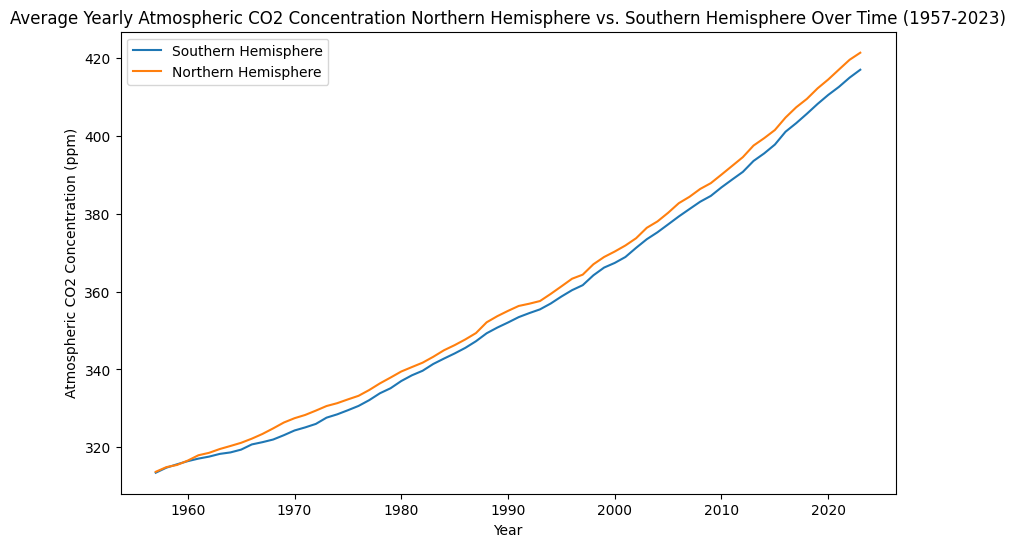

In [186]:
years = list(range(1957, 2024))
years = pd.DataFrame(years)

plt.figure(figsize = (10,6))

plt.plot(years, average_southern, label='Southern Hemisphere')
plt.plot(years, average_northern, label='Northern Hemisphere')


plt.xlabel('Year')
plt.ylabel('Atmospheric CO2 Concentration (ppm)')
plt.title('Average Yearly Atmospheric CO2 Concentration Northern Hemisphere vs. Southern Hemisphere Over Time (1957-2023)')
    
plt.legend(loc="upper left")
plt.show()

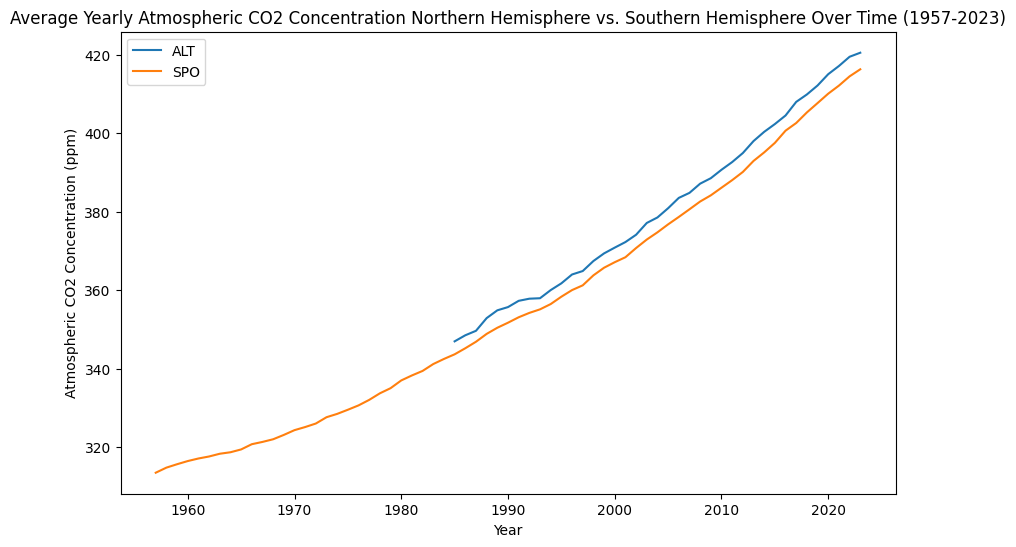